# Fast tokenizer's special power

## 1. Batch encoding

The output of a tokenizer isn’t a simple Python dictionary; what we get is actually a special `BatchEncoding` object. It’s a subclass of a dictionary (which is why we were able to index into that result without any problem before), but with additional methods that are mostly used by fast tokenizers.



Let’s take a look at an example:



In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "I'm testing a hypothesis called Mambula, and the result is great."
encoding = tokenizer(example)
encoding

{'input_ids': [101, 146, 112, 182, 5193, 170, 11066, 1270, 7085, 12913, 5886, 117, 1105, 1103, 1871, 1110, 1632, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

Since the `AutoTokenizer` class picks a fast tokenizer by default, we can use the additional methods this `BatchEncoding` object provides. We have two ways to check if our tokenizer is a fast or a slow one. We can either check the attribute `is_fast` of the tokenizer:



In [8]:
print(encoding.is_fast)
print(tokenizer.is_fast)

True
True


Let’s see what a fast tokenizer enables us to do. First, we can access the tokens without having to convert the IDs back to tokens:



In [9]:
encoding.tokens()

['[CLS]',
 'I',
 "'",
 'm',
 'testing',
 'a',
 'hypothesis',
 'called',
 'Ma',
 '##mb',
 '##ula',
 ',',
 'and',
 'the',
 'result',
 'is',
 'great',
 '.',
 '[SEP]']

We can also use the `word_ids()` method to get the index of the word each token comes from:

In [10]:
encoding.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 10, 11, 12, 13, 14, None]

We can see that the tokenizer’s special tokens `[CLS]` and `[SEP]` are mapped to `None`, and then each token is mapped to the word it originates from.

Similarly, there is a `sentence_ids()` method that we can use to map a token to the sentence it came from (though in this case, the `token_type_ids` returned by the tokenizer can give us the same information).



Lastly, we can map any word or token to characters in the original text, and vice versa, via the `word_to_chars()` or `token_to_chars()` and `char_to_word()` or `char_to_token()`.



In [18]:
start, end = encoding.word_to_chars(5)
print(start)
print(end)

14
24


In [17]:
result = encoding.char_to_word(18)
result

5

As we mentioned previously, this is all powered by the fact the fast tokenizer keeps track of the span of text each token comes from in a list of offsets. To illustrate their use, next we’ll show you how to replicate the results of the `token-classification` pipeline manually.



## 2. Inside the token-classification pipeline

### 2.1. Getting the base result with pipeline

First, let’s grab a token classification pipeline so we can get some results to compare manually. The model used by default is `dbmdz/bert-large-cased-finetuned-conll03-english`; it performs NER on sentences:



In [19]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: dbmdz/bert-large-cased-finetuned-conll03-english
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.bias   | UNEXPECTED |  | 
bert.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[{'entity': 'I-PER',
  'score': np.float32(0.99938285),
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': np.float32(0.99815494),
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': np.float32(0.99590707),
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': np.float32(0.99923277),
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': np.float32(0.9738931),
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': np.float32(0.976115),
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': np.float32(0.9887976),
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': np.float32(0.9932106),
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

We can also ask the pipeline to group together the tokens that correspond to the same entity:

In [20]:
token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: dbmdz/bert-large-cased-finetuned-conll03-english
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.bias   | UNEXPECTED |  | 
bert.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[{'entity_group': 'PER',
  'score': np.float32(0.9981694),
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': np.float32(0.9796019),
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': np.float32(0.9932106),
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

The `aggregation_strategy` picked will change the scores computed for each grouped entity. With "simple" the score is just the mean of the scores of each token in the given entity: for instance, the score of `“Sylvain”` is the mean of the scores we saw in the previous example for the tokens `S`, `##yl`, `##va`, and `##in`. Other strategies available are:



* `"first"`, where the score of each entity is the score of the first token of that entity (so for `“Sylvain”` it would be 0.993828, the score of the token `S`)

* `"max"`, where the score of each entity is the maximum score of the tokens in that entity (so for `“Hugging Face”` it would be 0.98879766, the score of `“Face”`)

* `"average"`, where the score of each entity is the average of the scores of the words composing that entity (so for `“Sylvain”` there would be no difference from the "simple" strategy, but `“Hugging Face”` would have a score of 0.9819, the average of the scores for `“Hugging”`, 0.975, and `“Face”`, 0.98879)

Now let’s see how to obtain these results without using the `pipeline()` function!



### 2.2. From inputs to predictions


First we need to tokenize our input and pass it through the model.

In [21]:
from transformers import AutoModelForTokenClassification

checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForTokenClassification.from_pretrained(checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: dbmdz/bert-large-cased-finetuned-conll03-english
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.bias   | UNEXPECTED |  | 
bert.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [22]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 8.7508, -2.2626, -1.5300, -2.2889, -0.6513, -2.0016, -0.0112,
          -2.0860,  0.3335],
         [ 8.4973, -2.3986, -1.3582, -2.7887,  0.7575, -1.8873,  0.4344,
          -1.9900, -0.3397],
         [ 9.4719, -2.2261, -0.9849, -2.6116,  0.1219, -2.0627, -0.1259,
          -1.8758, -0.0609],
         [ 9.8670, -2.2175, -1.3125, -2.4866, -0.2550, -1.8536,  0.0856,
          -1.7520, -0.6437],
         [-0.2011, -2.1873, -1.5316, -2.7110,  8.4025, -2.4168, -0.6980,
          -3.0337, -0.0997],
         [ 0.1065, -2.0520, -1.4787, -2.8139,  7.4525, -2.8399, -0.0626,
          -3.3666, -0.4683],
         [ 0.5985, -2.2538, -1.1926, -3.0111,  7.0070, -2.8675,  0.3492,
          -3.3129, -0.2878],
         [-0.0584, -2.2660, -1.4335, -3.1940,  8.3225, -2.6212, -0.0348,
          -2.9780, -0.2957],
         [ 9.6889, -2.4281, -1.5653, -2.5225, -0.9693, -1.5668,  0.4285,
          -1.9413, -0.6774],
         [ 9.0116, -2.1216, -1.4140, -2.69

Since we’re using `AutoModelForTokenClassification` here, we get one set of logits for each token in the input sequence:



In [23]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


Like for the text classification pipeline, we use a `softmax` function to convert those logits to probabilities, and we take the argmax to get predictions.

In [41]:
import torch

probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
preds = torch.argmax(probs, dim=-1).tolist()
max_prob = torch.max(probs, dim=-1)[0].tolist()
print(preds)
print(max_prob)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]
[0.9994322657585144, 0.9989632368087769, 0.9997084736824036, 0.9998351335525513, 0.9993828535079956, 0.9981549382209778, 0.995907187461853, 0.9992327690124512, 0.999804675579071, 0.9995046854019165, 0.9996775388717651, 0.999434769153595, 0.9738931059837341, 0.9761149883270264, 0.9887976050376892, 0.9995326995849609, 0.9932106137275696, 0.9994321465492249, 0.9994322657585144]


In [36]:
inputs.tokens()

['[CLS]',
 'My',
 'name',
 'is',
 'S',
 '##yl',
 '##va',
 '##in',
 'and',
 'I',
 'work',
 'at',
 'Hu',
 '##gging',
 'Face',
 'in',
 'Brooklyn',
 '.',
 '[SEP]']

The `model.config.id2label` attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:



In [35]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

As we saw earlier, there are 9 labels: `O` is the label for the tokens that are not in any named entity (it stands for “outside”), and we then have two labels for each type of entity (miscellaneous, person, organization, and location). The label `B-XXX` indicates the token is at the beginning of an entity `XXX` and the label `I-XXX` indicates the token is inside the entity `XXX`. For instance, in the current example we would expect our model to classify the token `S` as `B-PER` (beginning of a person entity) and the tokens `##yl`, `##va` and `##in` as `I-PER` (inside a person entity).



You might think the model was wrong in this case as it gave the label `I-PER` to all four of these tokens, but that’s not entirely true. There are actually two formats for those `B-` and `I-` labels: `IOB1` and `IOB2`. The `IOB2` format (in pink below), is the one we introduced whereas in the `IOB1` format (in blue), the labels beginning with `B-` are only ever used to separate two adjacent entities of the same type. The model we are using was fine-tuned on a dataset using that format, which is why it assigns the label `I-PER` to the `S` token.



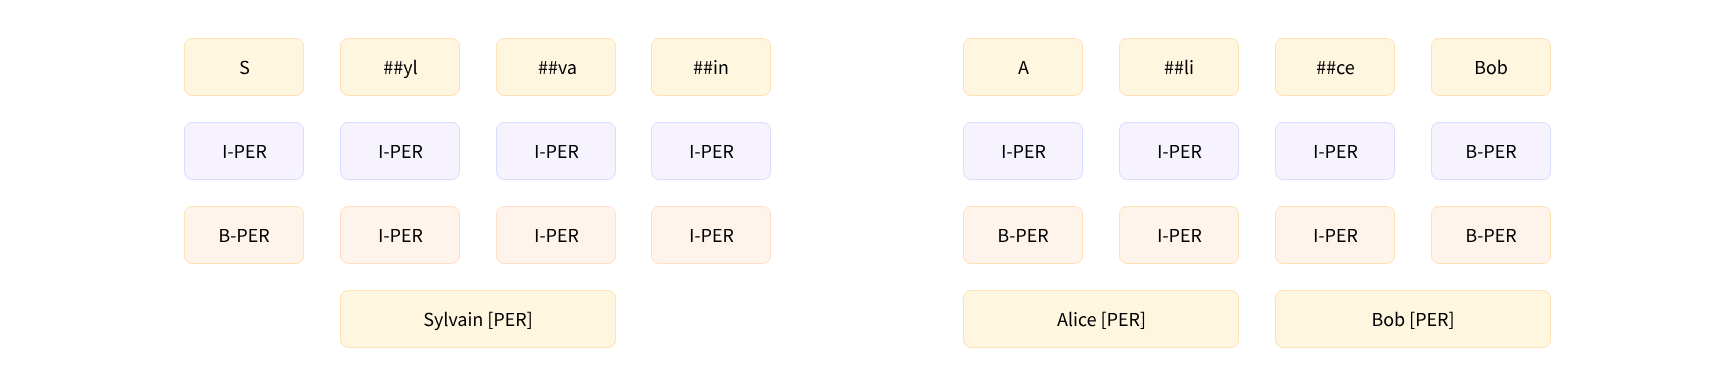

With this map, we are ready to reproduce (almost entirely) the results of the first pipeline — we can just grab the score and label of each token that was not classified as `O`:



In [46]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(preds):
    if pred != 0:
        label = model.config.id2label[pred]
        results.append({"entity": label, 
                        "score": max_prob[idx],
                        "index": idx, 
                        "word": tokens[idx]})
print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'index': 4, 'word': 'S'}, {'entity': 'I-PER', 'score': 0.9981549382209778, 'index': 5, 'word': '##yl'}, {'entity': 'I-PER', 'score': 0.995907187461853, 'index': 6, 'word': '##va'}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'index': 7, 'word': '##in'}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'index': 12, 'word': 'Hu'}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'index': 13, 'word': '##gging'}, {'entity': 'I-ORG', 'score': 0.9887976050376892, 'index': 14, 'word': 'Face'}, {'entity': 'I-LOC', 'score': 0.9932106137275696, 'index': 16, 'word': 'Brooklyn'}]


This is very similar to what we had before, with one exception: the `pipeline` also gave us information about the `start` and `end` of each entity in the original sentence. This is where our offset mapping will come into play. To get the offsets, we just have to set `return_offsets_mapping=True` when we apply the tokenizer to our inputs:



In [47]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 12),
 (12, 14),
 (14, 16),
 (16, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 35),
 (35, 40),
 (41, 45),
 (46, 48),
 (49, 57),
 (57, 58),
 (0, 0)]

Each tuple is the span of text corresponding to each token, where `(0, 0)` is reserved for the special tokens. We saw before that the token at index `5` is `##yl`, which has `(12, 14)` as offsets here. If we grab the corresponding slice in our example:



In [48]:
example[12: 14]

'yl'

we get the proper span of text without the `##`:



Using this, we can now complete the previous results:



In [50]:
results = []
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(preds):
    if pred != 0:
        label = model.config.id2label[pred]
        results.append({"entity": label, 
                        "score": max_prob[idx],
                        "index": idx, 
                        "word": tokens[idx],
                        "start": offsets[idx][0],
                        "end": offsets[idx][1]})
print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'index': 4, 'word': 'S', 'start': 11, 'end': 12}, {'entity': 'I-PER', 'score': 0.9981549382209778, 'index': 5, 'word': '##yl', 'start': 12, 'end': 14}, {'entity': 'I-PER', 'score': 0.995907187461853, 'index': 6, 'word': '##va', 'start': 14, 'end': 16}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'index': 7, 'word': '##in', 'start': 16, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'index': 12, 'word': 'Hu', 'start': 33, 'end': 35}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'index': 13, 'word': '##gging', 'start': 35, 'end': 40}, {'entity': 'I-ORG', 'score': 0.9887976050376892, 'index': 14, 'word': 'Face', 'start': 41, 'end': 45}, {'entity': 'I-LOC', 'score': 0.9932106137275696, 'index': 16, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


This is the same as what we got from the first pipeline!



### 2.3. Grouping entities

Using the offsets to determine the start and end keys for each entity is handy, but that information isn’t strictly necessary. When we want to group the entities together, however, the offsets will save us a lot of messy code. For example, if we wanted to group together the tokens `Hu`, `##gging`, and `Face`, we could make special rules that say the first two should be attached while removing the `##`, and the `Face` should be added with a space since it does not begin with `##` — but that would only work for this particular type of tokenizer. We would have to write another set of rules for a `SentencePiece` or a `Byte-Pair-Encoding` tokenizer.



With the offsets, all that custom code goes away: we just can take the span in the original text that begins with the first token and ends with the last token. So, in the case of the tokens `Hu`, `##gging`, and `Face`, we should start at character 33 (the beginning of `Hu`) and end before character 45 (the end of `Face`):



In [51]:
example[33:45]

'Hugging Face'

To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with `I-XXX`, except for the first one, which can be labeled as `B-XXX` or `I-XXX` (so, we stop grouping an entity when we get a `O`, a new type of entity, or a `B-XXX` that tells us an entity of the same type is starting):



In [64]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(preds):
    pred = preds[idx]
    if pred == 0: 
        idx += 1
        continue
    pred = preds[idx]
    label = model.config.id2label[pred]
    # Remove the B- or I-
    label = label[2:]
    start, end = offsets[idx]
    # Stores all score to compute mean score
    all_scores = []
    all_scores.append(max_prob[idx])
    idx += 1
    while (
        idx < len(preds) 
        and model.config.id2label[preds[idx]] == f"I-{label}"
    ):
        _, end = offsets[idx]
        all_scores.append(max_prob[idx])
        idx += 1
    
    score = np.mean(all_scores).item()
    word = example[start: end]
    results.append({
        "entity_group": label,
        "score": score,
        "start": start,
        "end": end
    })

print(results)

[{'entity_group': 'PER', 'score': 0.9981694370508194, 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9796018997828165, 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': 0.9932106137275696, 'start': 49, 'end': 57}]


And we get the same results as with our second pipeline!

